# 3.4 Simulating interaction and transmission

In this tutorial, you will learn how to customize how agents interact.

## Problem

In the previous tutorial, every agent interacted with every other agent. Here, you will instead implement a distance-based network (i.e., the closer together two agents are, the more likely they are to be connected).

In [ ]:
"""
Original code for tutorial 3.4
"""

import numpy as np
import sciris as sc
import pylab as pl


# Set default parameters
default_pars = sc.objdict(
    beta = 0.3, # Infection rate per contact per unit time
    gamma = 0.5, # Recovery rate
    n_contacts = 10, # Number of people each person is connected to
    distance = 0.1, # The distance over which people form contacts
    I0 = 1, # Number of people initially infected
    N = 1000, # Total population size
    maxtime = 20, # How long to simulate for
    npts = 100, # Number of time points during the simulation
    seed = 3, # Random seed to use -- NB, not all seeds "take off"
    colors = sc.objdict(S='darkgreen', I='gold', R='skyblue'),
    save_movie = False, # Whether to save the movie (slow)
)


class Person(sc.dictobj):
    """
    Define each person (agent) in SimpleABM

    They have three (mutually exclusive) states: susceptible (S), infected (I),
    recovered (R). They also have x,y coordinates for plotting.
    """

    def __init__(self, pars):
        self.pars = pars
        self.S = True # People start off susceptible
        self.I = False
        self.R = False
        # EXERCISE: give each agent a random position between [0,1] in the x and y planes

    def infect(self):
        self.S = False
        self.I = True

    def recover(self):
        self.I = False
        self.R = True

    def check_infection(self, other):
        pars = self.pars
        if self.S: # A person must be susceptible to be infected
            if other.I: # The other person must be infectious
                if np.random.rand() < pars.beta*pars.dt: # Infection is probabilistic
                    self.infect()

    def check_recovery(self):
        pars = self.pars
        if self.I: # A person must be infected to recover
            if np.random.rand() < pars.gamma*pars.dt: # Recovery is also probabilistic
                self.recover()


class Sim(sc.dictobj):
    """
    Define the simulation
    """

    def __init__(self, **kwargs):
        pars = sc.mergedicts(default_pars, kwargs) # Parameters to use
        pars.dt = pars.maxtime/pars.npts # Timestep length
        self.T = np.arange(pars.npts)
        self.time = self.T*pars.dt
        self.pars = pars
        self.initialize()

    def initialize(self):
        """ Initialize everything (sim can be re-initialized as well) """
        pars = self.pars

        # Initilaize people and the network
        np.random.seed(pars.seed)
        self.people = [Person(pars) for i in range(pars.N)] # Create all the people
        for person in self.people[0:pars.I0]: # Make the first I0 people infectious
            person.infect() # Set the initial conditions
        self.make_network()

        # Initial conditions
        self.S = np.zeros(pars.npts)
        self.I = np.zeros(pars.npts)
        self.R = np.zeros(pars.npts)
        self.S_full = []
        self.I_full = []
        self.R_full = []

    # EXERCISE: write a method "get_xy" that returns arrays for the x and y coordinates of all agents
    def get_xy(self):


    # EXERCISE: write a method "make_network" that:
    # 1. Calculates the Euclidean distance between each possible pair of agents
    # 2. Computes a random number for each possible pair
    # 3. Sorts the pairs by distance divided by the random numbers
    # 4. Selects the top N*n_contacts/2 pairs to form connections
    # 5. Sets this as self.contacts
    def make_network(self):
        """ Create the network by pairing agents who are close to each other """

    # EXERCISE: write a method "check_infections" that checks for infections among pairs of people in the contacts
    def check_infections(self):
        """ Check which agents become infected """

    def check_recoveries(self):
        """ Check which agents recover """
        for person in self.people:
            person.check_recovery()

    def count(self, t):
        """ Count the number of agents in each state """
        this_S = []
        this_I = []
        this_R = []
        for i,person in enumerate(self.people):
            if person.S: this_S.append(i)
            if person.I: this_I.append(i)
            if person.R: this_R.append(i)

        self.S[t] += len(this_S)
        self.I[t] += len(this_I)
        self.R[t] += len(this_R)

        self.S_full.append(this_S)
        self.I_full.append(this_I)
        self.R_full.append(this_R)

    def run(self):
        """ Run the simulation by integrating over time """
        for t in self.T:
            self.check_infections() # Check which infectious occur
            self.check_recoveries() # Check which recoveries occur
            self.count(t) # Store results

    def plot(self):
        """ Plot numbers of S, I, R over time """
        pl.figure()
        cols = self.pars.colors
        pl.plot(self.time, self.S, label='Susceptible', c=cols.S)
        pl.plot(self.time, self.I, label='Infected', c=cols.I)
        pl.plot(self.time, self.R, label='Recovered', c=cols.R)
        pl.legend()
        pl.xlabel('Time')
        pl.ylabel('Number of people')
        pl.ylim(bottom=0)
        pl.xlim(left=0)
        pl.show()

    def animate(self, pause=0.01, save=False):
        """ Create an animation of the infection as it spreads across the network """
        anim = sc.animation()
        fig,ax = pl.subplots()
        x,y = self.get_xy()
        for p in self.contacts:
            p0 = p[0]
            p1 = p[1]
            pl.plot([x[p0], x[p1]], [y[p0], y[p1]], lw=0.5, alpha=0.1, c='k')

        handles = []
        for t in self.T[:-1]:
            if pl.fignum_exists(fig.number):
                for h in handles:
                    h.remove()
                handles = []
                counts = sc.dictobj()
                inds = sc.dictobj()
                for key,fullkey in [('S', 'S_full'), ('I', 'I_full'), ('R', 'R_full')]:
                    inds[key] = self[fullkey][t]
                    counts[key] = len(inds[key])
                    this_x = x[inds[key]]
                    this_y = y[inds[key]]
                    h = ax.scatter(this_x, this_y, c=self.pars.colors[key])
                    handles.append(h)
                title = f't={t}, S={counts.S}, I={counts.I}, R={counts.R}'
                pl.title(title)
                pl.pause(pause)
                if save:
                    anim.addframe()

        if save:
            anim.save(f'network_{self.pars.distance}.mp4')


if __name__ == '__main__':

    # Create and run the simulation
    sim = Sim()
    sim.run()
    sim.plot()

## Solution

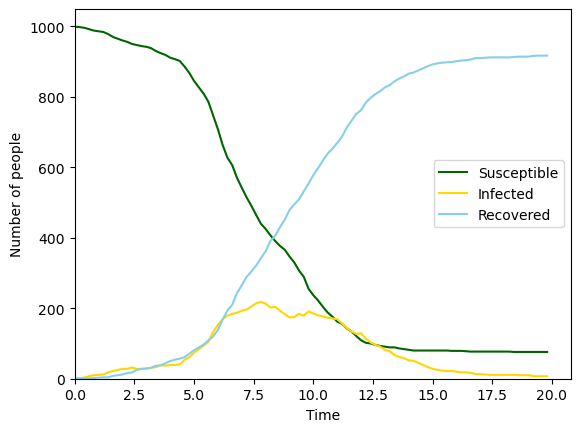

In [1]:
"""
Solution for tutorial 3.4
"""

import numpy as np
import sciris as sc
import pylab as pl


# Set default parameters
default_pars = sc.objdict(
    beta = 0.3, # Infection rate per contact per unit time
    gamma = 0.5, # Recovery rate
    n_contacts = 10, # Number of people each person is connected to
    distance = 0.1, # The distance over which people form contacts
    I0 = 1, # Number of people initially infected
    N = 1000, # Total population size
    maxtime = 20, # How long to simulate for
    npts = 100, # Number of time points during the simulation
    seed = 3, # Random seed to use -- NB, not all seeds "take off"
    colors = sc.objdict(S='darkgreen', I='gold', R='skyblue'),
    save_movie = False, # Whether to save the movie (slow)
)


class Person(sc.dictobj):
    """
    Define each person (agent) in SimpleABM

    They have three (mutually exclusive) states: susceptible (S), infected (I),
    recovered (R). They also have x,y coordinates for plotting.
    """

    def __init__(self, pars):
        self.pars = pars
        self.S = True # People start off susceptible
        self.I = False
        self.R = False
        # EXERCISE: give each agent a random position between [0,1] in the x and y planes
        self.x = np.random.rand()
        self.y = np.random.rand()

    def infect(self):
        self.S = False
        self.I = True

    def recover(self):
        self.I = False
        self.R = True

    def check_infection(self, other):
        pars = self.pars
        if self.S: # A person must be susceptible to be infected
            if other.I: # The other person must be infectious
                if np.random.rand() < pars.beta*pars.dt: # Infection is probabilistic
                    self.infect()

    def check_recovery(self):
        pars = self.pars
        if self.I: # A person must be infected to recover
            if np.random.rand() < pars.gamma*pars.dt: # Recovery is also probabilistic
                self.recover()


class Sim(sc.dictobj):
    """
    Define the simulation
    """

    def __init__(self, **kwargs):
        pars = sc.mergedicts(default_pars, kwargs) # Parameters to use
        pars.dt = pars.maxtime/pars.npts # Timestep length
        self.T = np.arange(pars.npts)
        self.time = self.T*pars.dt
        self.pars = pars
        self.initialize()

    def initialize(self):
        """ Initialize everything (sim can be re-initialized as well) """
        pars = self.pars

        # Initilaize people and the network
        np.random.seed(pars.seed)
        self.people = [Person(pars) for i in range(pars.N)] # Create all the people
        for person in self.people[0:pars.I0]: # Make the first I0 people infectious
            person.infect() # Set the initial conditions
        self.make_network()

        # Initial conditions
        self.S = np.zeros(pars.npts)
        self.I = np.zeros(pars.npts)
        self.R = np.zeros(pars.npts)
        self.S_full = []
        self.I_full = []
        self.R_full = []

    # EXERCISE: write a method "get_xy" that returns arrays for the x and y coordinates of all agents
    def get_xy(self):
        """ Get the location of each agent """
        x = np.array([p.x for p in self.people])
        y = np.array([p.y for p in self.people])
        return x,y

    # EXERCISE: write a method "make_network" that:
    # 1. Calculates the Euclidean distance between each possible pair of agents
    # 2. Computes a random number for each possible pair
    # 3. Sorts the pairs by distance divided by the random numbers
    # 4. Selects the top N*n_contacts/2 pairs to form connections
    # 5. Sets this as self.contacts
    def make_network(self):
        """ Create the network by pairing agents who are close to each other """
        pars = self.pars
        x,y = self.get_xy()
        dist = np.zeros((pars.N, pars.N))
        for i in range(pars.N):
            dist[i,:] = 1 + ((x - x[i])**2 + (y - y[i])**2)**0.5/self.pars.distance
            dist[i,i] = np.inf

        rnds = np.random.rand(pars.N, pars.N)
        ratios = dist/rnds
        order = np.argsort(ratios, axis=None)
        inds = order[0:int(pars.N*pars.n_contacts/2)]
        contacts = np.unravel_index(inds, ratios.shape)
        self.contacts = np.vstack(contacts).T

    # EXERCISE: write a method "check_infections" that checks for infections among pairs of people in the contacts
    def check_infections(self):
        """ Check which agents become infected """
        for p1,p2 in self.contacts:
            person1 = self.people[p1]
            person2 = self.people[p2]
            person1.check_infection(person2)
            person2.check_infection(person1)

    def check_recoveries(self):
        """ Check which agents recover """
        for person in self.people:
            person.check_recovery()

    def count(self, t):
        """ Count the number of agents in each state """
        this_S = []
        this_I = []
        this_R = []
        for i,person in enumerate(self.people):
            if person.S: this_S.append(i)
            if person.I: this_I.append(i)
            if person.R: this_R.append(i)

        self.S[t] += len(this_S)
        self.I[t] += len(this_I)
        self.R[t] += len(this_R)

        self.S_full.append(this_S)
        self.I_full.append(this_I)
        self.R_full.append(this_R)

    def run(self):
        """ Run the simulation by integrating over time """
        for t in self.T:
            self.check_infections() # Check which infectious occur
            self.check_recoveries() # Check which recoveries occur
            self.count(t) # Store results

    def plot(self):
        """ Plot numbers of S, I, R over time """
        pl.figure()
        cols = self.pars.colors
        pl.plot(self.time, self.S, label='Susceptible', c=cols.S)
        pl.plot(self.time, self.I, label='Infected', c=cols.I)
        pl.plot(self.time, self.R, label='Recovered', c=cols.R)
        pl.legend()
        pl.xlabel('Time')
        pl.ylabel('Number of people')
        pl.ylim(bottom=0)
        pl.xlim(left=0)
        pl.show()

    def animate(self, pause=0.01, save=False):
        """ Create an animation of the infection as it spreads across the network """
        anim = sc.animation()
        fig,ax = pl.subplots()
        x,y = self.get_xy()
        for p in self.contacts:
            p0 = p[0]
            p1 = p[1]
            pl.plot([x[p0], x[p1]], [y[p0], y[p1]], lw=0.5, alpha=0.1, c='k')

        handles = []
        for t in self.T[:-1]:
            if pl.fignum_exists(fig.number):
                for h in handles:
                    h.remove()
                handles = []
                counts = sc.dictobj()
                inds = sc.dictobj()
                for key,fullkey in [('S', 'S_full'), ('I', 'I_full'), ('R', 'R_full')]:
                    inds[key] = self[fullkey][t]
                    counts[key] = len(inds[key])
                    this_x = x[inds[key]]
                    this_y = y[inds[key]]
                    h = ax.scatter(this_x, this_y, c=self.pars.colors[key])
                    handles.append(h)
                title = f't={t}, S={counts.S}, I={counts.I}, R={counts.R}'
                pl.title(title)
                pl.pause(pause)
                if save:
                    anim.addframe()

        if save:
            anim.save(f'network_{self.pars.distance}.mp4')


if __name__ == '__main__':

    # Create and run the simulation
    sim = Sim()
    sim.run()
    sim.plot()

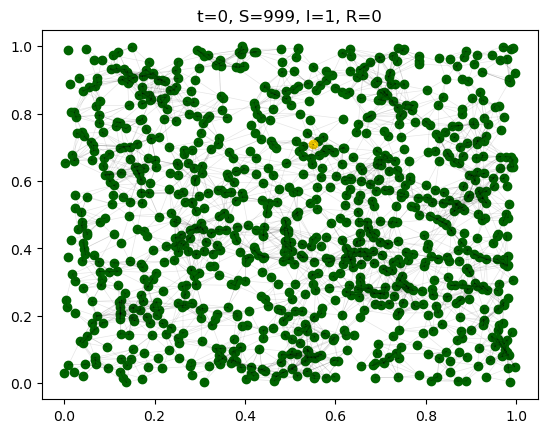

In [2]:
sim.animate()